# Boston 주택 가격 예측 모델

- 파라미터 설명

|feature|설명|
|-------|---|
|CRIM|자치시별 1인당 범죄율|
|ZN|25,000 평방피트를 초과하는 거주지역의 비율|
|INDUS|비소매상업지역이 점유하고 있는 토지의 비율|
|CHAS|찰스강에 대한 더미변수(강의 경계에 위치한 경우는 1, 아니면 0)|
|NOX|10ppm 당 농축 일산화질소|
|RM|주택 1 가구당 평균 방의 개수|
|AGE|1940년 이전에 건축된 소유주택의 비율|
|DIS|5개의 보스턴 직업센터까지의 접근성 지수|
|RAD|방사형 도로까지의 접근성 지수|
|TAX|10,000 달러당 재산세율|
|PTRATIO|자치시(town)별 학생/교사 비율|
|B|$$1000(Bk-0.63)^2$$ 여기서 Bk는 자치시별 흑인의 비율을 말함|
|LSTAT|모집단의 하위계층의 비율(%)|
|MEDV|본인 소유의 주택가격(중앙값)(단위: $1,000)|

In [1]:
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
# keras.datasets 안에 boston_housing 데이터셋을 로드합니다.
from keras.datasets import boston_housing

(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

# 데이터셋의 크기를 확인합니다.
print(len(train_data))
print(len(test_data))

404
102


In [3]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

train_data = train_data - mean
train_data = train_data/std

test_data = test_data - mean
test_data = test_data/std

### 1. 모델 설계
- 다층으로 하되, 드롭아웃을 이용하여 오버피팅을 제한하였다.(사전에 정규화를 진행하였기에 배치정규화는 실시하지 않았다.)
- 옵티마이저 방식은 adam으로 결정하고, 손실함수는 mse로 정의하였다. 평가지표는 회귀이므로 accuracy가 아닌 mae로 선정하였다.

In [4]:
model = models.Sequential()
model.add(layers.Dense(128, input_shape=(train_data.shape[1], ), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='relu'))

model.summary()
model.compile(optimizer='adam', loss=['mse'], metrics=['mae'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1792      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3

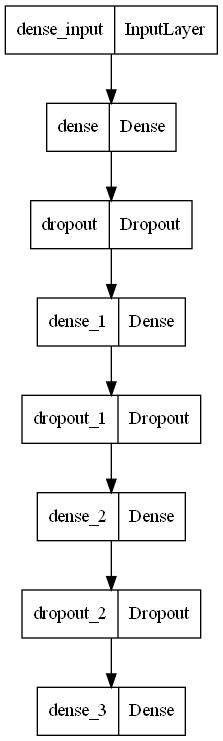

In [5]:
from tensorflow.keras import utils
utils.plot_model(model)

- 에폭스는 50회, 배치 사이즈는 25, 하이퍼파라미터 평가용 데이터는 20%정도 구분하였다.

In [6]:
history = model.fit(train_data, train_labels, epochs=50, batch_size=25, validation_split=0.2)

Epoch 1/50
13/13 [==============================] - 3s 26ms/step - loss: 535.4875 - mae: 21.2360 - val_loss: 568.7722 - val_mae: 22.0600
Epoch 2/50
13/13 [==============================] - 0s 8ms/step - loss: 452.7227 - mae: 19.2610 - val_loss: 448.5406 - val_mae: 19.2078
Epoch 3/50
13/13 [==============================] - 0s 8ms/step - loss: 315.5880 - mae: 15.3585 - val_loss: 255.5469 - val_mae: 13.6574
Epoch 4/50
13/13 [==============================] - 0s 8ms/step - loss: 158.7560 - mae: 10.1837 - val_loss: 97.8457 - val_mae: 7.3815
Epoch 5/50
13/13 [==============================] - 0s 8ms/step - loss: 105.0715 - mae: 7.7194 - val_loss: 62.3027 - val_mae: 5.9592
Epoch 6/50
13/13 [==============================] - 0s 8ms/step - loss: 77.7344 - mae: 6.7274 - val_loss: 52.7336 - val_mae: 5.1983
Epoch 7/50
13/13 [==============================] - 0s 7ms/step - loss: 70.8429 - mae: 6.0610 - val_loss: 40.7670 - val_mae: 4.4879
Epoch 8/50
13/13 [==============================] - 0s 6ms/s

### 2. 하이퍼 파라미터 평가
- validation data와 비교해서 학습데이터의 로스가 높은 것을 보아 오버피팅 문제는 없어 보인다

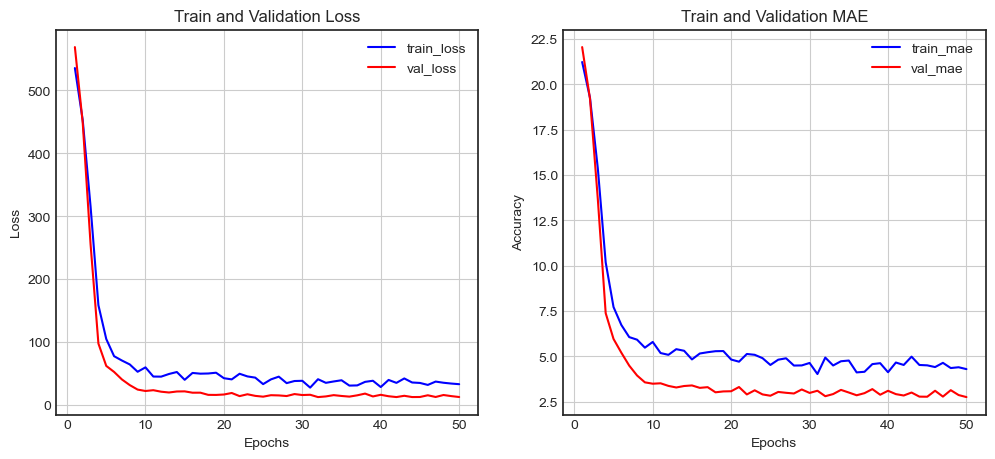

In [7]:
# 모델 학습 히스토리에서 loss, val_loss, mae, val_mae를 차트로 보여줍니다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

mae = history_dict['mae']
val_mae = history_dict['val_mae']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, mae, 'b-', label='train_mae')
ax2.plot(epochs, val_mae, 'r-', label='val_mae')
ax2.set_title('Train and Validation MAE')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

### 3. 테스트 데이터를 이용하여 모델을 평가

In [8]:
from sklearn.metrics import mean_squared_error
test_pred = model.predict(test_data)
mse = mean_squared_error(test_labels, test_pred)
print(mse)
model.evaluate(test_data, test_labels)

4/4 [==============================] - 0s 0s/step
23.26943185420613
4/4 [==============================] - 0s 3ms/step - loss: 23.2694 - mae: 3.1459


[23.26943016052246, 3.145944595336914]

- sklearn의 mse와 비교해봐서, 텐서플로우 평가시의 앞전의 loss으로 정의한 mse임을 알 수 있었다.

# Reuters 딥러닝 모델

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from keras.datasets import reuters

## 1. 데이터 로드

- 1만개로 단어 개수 제한

In [24]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25, random_state=1)

print(len(train_data))
print(len(val_data))
print(len(test_data))
print(len(set(train_labels)))

6736
2246
2246
46


In [26]:
def one_hot_encoding(data, dim=10000):
  results = np.zeros((len(data), dim))
  for i, d in enumerate(data):
    results[i, d] = 1.
  return results

x_train = one_hot_encoding(train_data)
x_val = one_hot_encoding(val_data)
x_test = one_hot_encoding(test_data)

y_train = utils.to_categorical(train_labels)
y_val = utils.to_categorical(val_labels)
y_test = utils.to_categorical(test_labels)

In [27]:
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(10000, ), name='input'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dense(256, activation='relu', kernel_regularizer='l1', name='hidden1'))
model.add(layers.Dense(128, activation='relu', name='hidden2'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(46, activation='softmax', name='output'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 128)               1280128   
                                                                 
 batch_normalization_3 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 128)               0         
                                                                 
 hidden1 (Dense)             (None, 256)               33024     
                                                                 
 hidden2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                      

In [28]:
check_point_cb = callbacks.ModelCheckpoint('keras_mnist_model.h5')
early_stopping_cb = callbacks.EarlyStopping(patience=3, monitor='val_loss',
                                  restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=10,
                    validation_data=(x_val, y_val),
                    callbacks=[check_point_cb, early_stopping_cb])

Epoch 1/10
211/211 [==============================] - 3s 11ms/step - loss: 6.4540 - accuracy: 0.6263 - val_loss: 2.1393 - val_accuracy: 0.6799
Epoch 2/10
211/211 [==============================] - 2s 10ms/step - loss: 1.5704 - accuracy: 0.7265 - val_loss: 1.6965 - val_accuracy: 0.7035
Epoch 3/10
211/211 [==============================] - 2s 9ms/step - loss: 1.2863 - accuracy: 0.7721 - val_loss: 1.6061 - val_accuracy: 0.7297
Epoch 4/10
211/211 [==============================] - 2s 10ms/step - loss: 1.1201 - accuracy: 0.8085 - val_loss: 1.6976 - val_accuracy: 0.7289
Epoch 5/10
211/211 [==============================] - 2s 10ms/step - loss: 1.0130 - accuracy: 0.8306 - val_loss: 1.6445 - val_accuracy: 0.7462
Epoch 6/10
211/211 [==============================] - 2s 11ms/step - loss: 0.9371 - accuracy: 0.8450 - val_loss: 1.6593 - val_accuracy: 0.7507


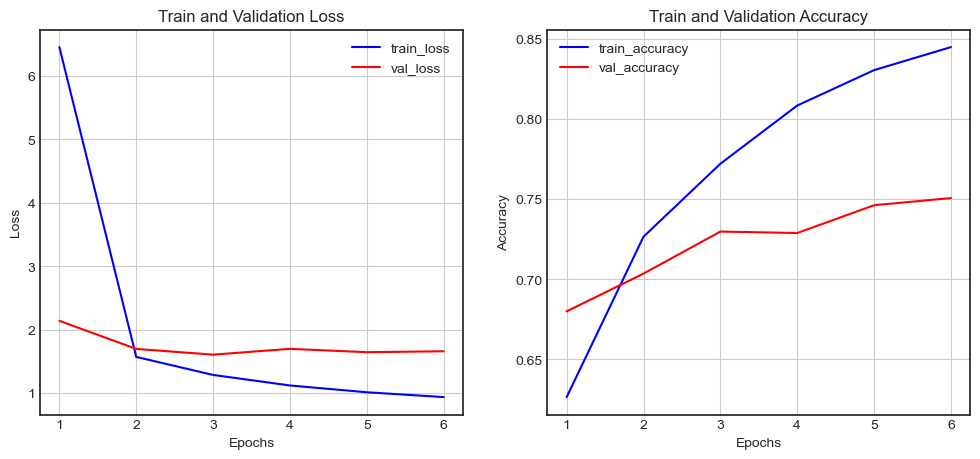

In [29]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [30]:
model.evaluate(x_test, y_test)

71/71 [==============================] - 1s 7ms/step - loss: 1.6280 - accuracy: 0.7217


[1.6279704570770264, 0.7217274904251099]

# CIFAR10 딥러닝 모델

## 1. 데이터 로드 및 전처리

In [37]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras.datasets import cifar10

In [44]:
(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.2, random_state=1)

# 훈련, 검증, 테스트 데이터와 레이블 종류가 몇개인지 출력합니다.
print("전체 학습 데이터: {} 레이블: {}".format(x_train_full.shape, y_train_full.shape))
print("학습 데이터: {} 레이블: {}".format(x_train.shape, y_train.shape))
print("검증 데이터: {} 레이블: {}".format(x_val.shape, y_val.shape))
print("테스트 데이터: {} 레이블: {}".format(x_test.shape, y_test.shape))

전체 학습 데이터: (50000, 32, 32, 3) 레이블: (50000, 1)
학습 데이터: (40000, 32, 32, 3) 레이블: (40000, 1)
검증 데이터: (10000, 32, 32, 3) 레이블: (10000, 1)
테스트 데이터: (10000, 32, 32, 3) 레이블: (10000, 1)


In [45]:
# cifar10의 분류에 해당하는 'airplane', 'automobile', 'bird', 'cat', 'deer', 
# 'dog', 'frog', 'horse', 'ship', 'truck'를 class_name으로 정의합니다.
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

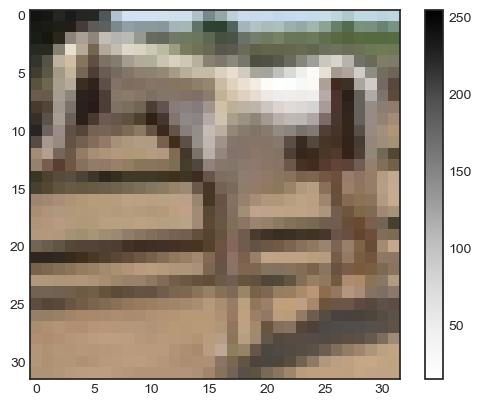

In [46]:
# 훈련 데이터의 0번째인 x_train[0]를 이미지로 시각화합니다.
plt.style.use('seaborn-white')

plt.figure()
plt.imshow(x_train[0])
plt.colorbar()
plt.show()

In [47]:
# 훈련, 검증, 테스트 데이터의 형태(shape)을 출력합니다.
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)


- 왜 굳이 리세잎을 시키는 지는 잘 이해가 안간다.

In [50]:
x_train = x_train.reshape(-1,3072)
x_val = x_val.reshape(-1,3072)
x_test = x_test.reshape(-1,3072)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(40000, 3072)
(10000, 3072)
(10000, 3072)


- 민맥스 스케일을 실시!

In [51]:
x_train = x_train / 255.
x_val = x_val / 255.
x_test = x_test / 255.

In [55]:
model = models.Sequential()
model.add(layers.Input(shape=(3072, )))
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              6293504   
                                                                 
 batch_normalization_5 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 2048)              0         
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 batch_normalization_6 (Batc  (None, 1024)             4096      
 hNormalization)                                      

- 동영상에 공유된 노드와 똑같은 모양으로 짜봤다

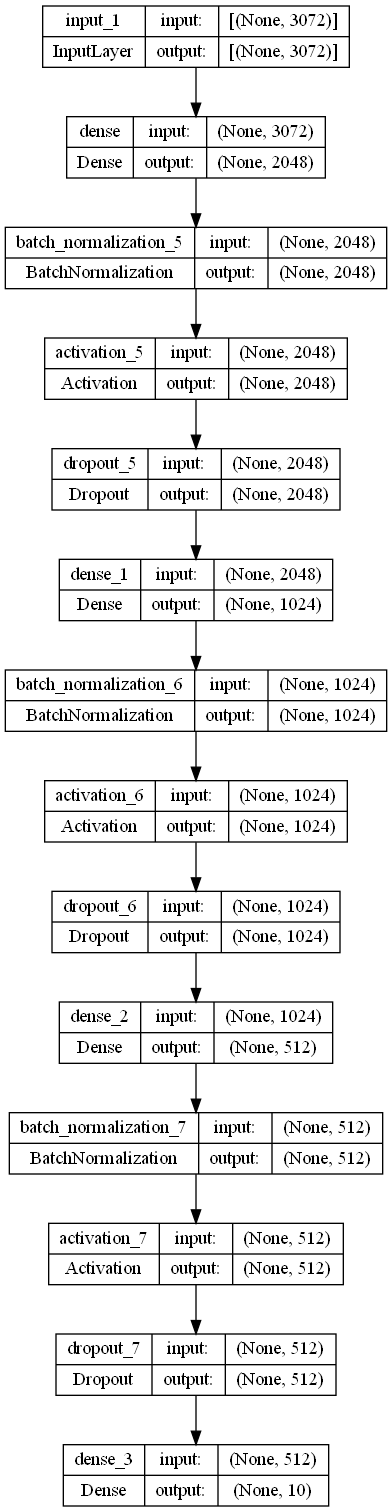

In [57]:
utils.plot_model(model, show_shapes=True)

- 옵티마이저 : 아담, 다중 클래스에 맞게 로스함수를 구성하였다.

In [56]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [58]:
check_point_cb = callbacks.ModelCheckpoint('keras_mnist_model.h5')
early_stopping_cb = callbacks.EarlyStopping(patience=3, monitor='val_loss',
                                  restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=10,
                    validation_data=(x_val, y_val),
                    callbacks=[check_point_cb, early_stopping_cb])

Epoch 1/10
1250/1250 [==============================] - 17s 11ms/step - loss: 2.2458 - accuracy: 0.2463 - val_loss: 1.9131 - val_accuracy: 0.3377
Epoch 2/10
1250/1250 [==============================] - 12s 10ms/step - loss: 1.9256 - accuracy: 0.3135 - val_loss: 1.8524 - val_accuracy: 0.3688
Epoch 3/10
1250/1250 [==============================] - 12s 9ms/step - loss: 1.8500 - accuracy: 0.3386 - val_loss: 1.8034 - val_accuracy: 0.3937
Epoch 4/10
1250/1250 [==============================] - 11s 9ms/step - loss: 1.8123 - accuracy: 0.3485 - val_loss: 1.7337 - val_accuracy: 0.4011
Epoch 5/10
1250/1250 [==============================] - 11s 9ms/step - loss: 1.7828 - accuracy: 0.3629 - val_loss: 1.7210 - val_accuracy: 0.4014
Epoch 6/10
1250/1250 [==============================] - 11s 9ms/step - loss: 1.7596 - accuracy: 0.3697 - val_loss: 1.6798 - val_accuracy: 0.4173
Epoch 7/10
1250/1250 [==============================] - 11s 9ms/step - loss: 1.7521 - accuracy: 0.3746 - val_loss: 1.6784 - val_

결과적으로 "얼리스타핑" 콜백함수는 작동하지 않았다.

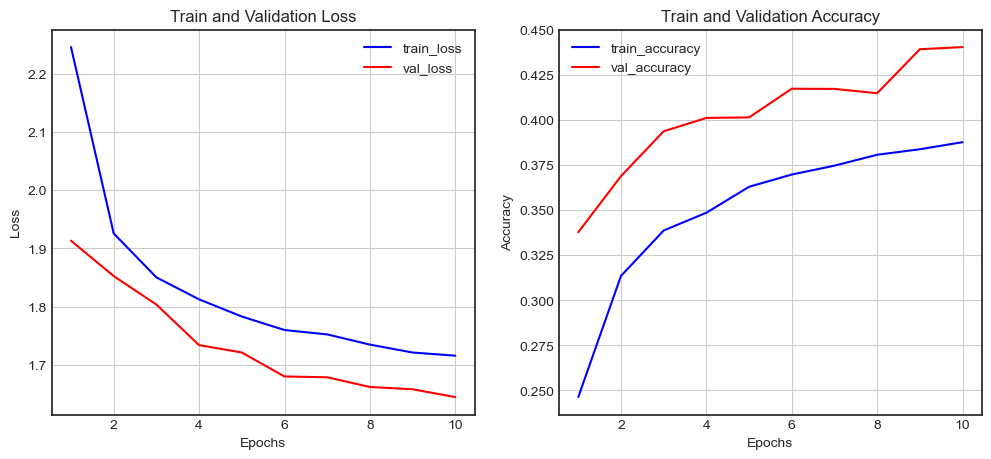

In [59]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss) + 1)

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color='blue', label='train_loss')
ax1.plot(epochs, val_loss, color='red', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, color='blue', label='train_accuracy')
ax2.plot(epochs, val_accuracy, color='red', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [60]:
# 테스트 데이터셋을 이용해 모델을 평가합니다.
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 1.6273 - accuracy: 0.4426


[1.6273016929626465, 0.4426000118255615]

# 회고

## Keep
- 회귀분석에는 제가 생각하는 제약을 다 넣어보았습니다.

## Problem
- 오늘 conda에다가 cuda, cudnn을 세팅하고, tensorflow GPU, sklearn, matplotlib, seaborn 등 다양한 라이브러리를 설치하느라 시간이 너무 걸렸다.

## Try
- 그래도 visual studio로 ipynb파일을 완성하여 좋았다.